# Li-Cor Li-200R Transimpedance Amplifier Calculations
This notebook contains the information and calculations uesd to design the transimpedance amplifier used to convert the current output of the Li-200R Pyranometer to a voltage output readable by an ADC.

## Assumptions and initial values
* According to [Newport](https://www.newport.com/introduction-to-solar-radiation), the maximum incoming solar radiation on a horizontal surface at ground level is $1120 W/m^2$
* The supply voltage is 3.3V
* The rails are at most 100mV away from the supply. The datasheet indicates differently but this is the starting assumption
* Nominal value for Li-200R output is $(75 \mu A) / (1000 W/m^2)$
* The ADC used to read is 12-bit
* Information about feedback capacitor selection was found [here](http://www.planetanalog.com/document.asp?doc_id=527534) and [here](https://en.wikipedia.org/wiki/Transimpedance_amplifier).

## Transimpedance Amplifier
![Li-200R Transimpedance Amplifer](Li200-Transimpedance-Amplifier.png)

The schematic above will be used in the analysis of the amplifier behavior. The three rules of ideal op-amp behavior will be used:
1. The op-amp output can source infinite current
2. The voltage at the two inputs to the op-amp are identical
3. There resistance at the two inputs of the op-amp is infinite; no current can flow into the inputs of the op-amp

The analysis is as follows:

1. The voltage at V2 is 0, so the voltage at V1 is 0
2. The current through R1 is identical to the current through the Li-200R. This is written as $I_{R1} = I_{Li-200R}$
3. The current through R1 is $I_{R1} = \frac{V3 - V1}{R1} = \frac{V3 - 0}{R1} = V3/R1$
4. The nominal current through the Li-200R is listed above and equal to the current through R1: $I_{Li-200R} = V3/R1$
5. The desired voltage at the output of the amplifier is $V3 = I_{Li-200R}*R1$. In other words, the gain of the amplifier is equal to value of $R1$, so $R1$ is chosen by $V3/I_{Li-200R}$.

The following code calculates the values required, accounting for a "safety factor" so the amplifier doesn't rail. 

*Note: The above schematic doesn't show the 0.1$\mu$F bypass capacitor on VDD*

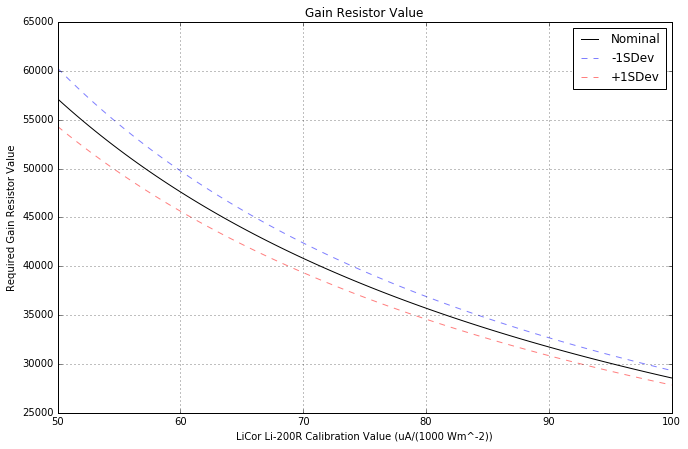

A Li200 with a calibration constant of 9.254000000000001e-08 A/(Wm^-2) would require a resistor of 30874.679675198364 ohms


In [6]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

# Initialize Variables
maxSunlight = 1120    # Wm^-2
supplyV = 3.3         # V
railOffset = 0.05     # V
liOut = 92.54e-6/1000    # A/(Wm^-2)
liSDev = 2.6e-6/1000  # A/(Wm^-2)
resolution = 2**12    # Bits
V3 = supplyV - railOffset   # Maximum desired output of op-amp

# Set up currents
mI = np.arange(50e-6,100e-6,0.5e-6)/1000  # Nominal current values - A/(Wm^-2)
lI = mI - liSDev                 # One standard deviation less than nominal
hI = mI + liSDev                 # One standard deviation greater than nominal

# Convert A/(Wm^-2) to A by multiplying max sunlight
mIMax = mI*maxSunlight
lIMax = lI*maxSunlight
hIMax = hI*maxSunlight
sMax = liOut*maxSunlight    # Find values for any given sensor instead of range

# Calculate resistance values
mR = V3/mIMax
lR = V3/lIMax
hR = V3/hIMax
sR = V3/sMax

# Plot
plt.figure(figsize=(11,7))
plt.xlabel('LiCor Li-200R Calibration Value (uA/(1000 Wm^-2))')
plt.ylabel('Required Gain Resistor Value')
plt.title('Gain Resistor Value')
plt.plot(mI*1000*1e6, mR, '-', color='k', alpha=1.0, label='Nominal')
plt.plot(mI*1000*1e6, lR, '--', color='b', alpha=0.5, label='-1SDev')
plt.plot(mI*1000*1e6, hR, '--', color='r', alpha=0.5, label='+1SDev')
plt.grid(True)
plt.legend()
plt.show()

# Print
print("A Li200 with a calibration constant of", liOut, "A/(Wm^-2) would require a resistor of", sR, "ohms")